In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json

In [26]:
TARGET_FIELDS = ["mdi_scores", "entropy_scores", "shift_scores", "eval_scores"]
# TARGET_FIELDS = ["mdi_scores", "shift_scores", "eval_scores"]

In [27]:
def jsonl_to_df_exp1(path, model_name, turn_type="single"):
    rows = []

    with open(path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            entry = json.loads(line)

            for field in TARGET_FIELDS:
                if field not in entry:
                    continue

                metric_block = entry[field]

                # -------------------------------------------
                # NORMAL METRICS (mdi, entropy, shift)
                # -------------------------------------------
                if field != "eval_scores":
                    for caption_type, lvl_dict in metric_block.items():
                        for level, value in lvl_dict.items():
                            if value is None:
                                continue
                            rows.append({
                                "model": model_name,
                                "turn_type": turn_type,
                                "metric_type": field,
                                "caption_type": caption_type,   # correct/incorrect
                                "level": level,
                                "value": value
                            })
                    continue

                # -------------------------------------------
                # SPECIAL CASE: EVAL_SCORES
                # Case 1: dict → {correct_caption_score, incorrect_caption_score}
                # Case 2: int → correctness only
                # -------------------------------------------
                for level, value in metric_block.items():

                    # Case 1 — dict with both scores
                    if isinstance(value, dict):
                        # correct_caption_score
                        corr = value.get("correct_caption_score")
                        rows.append({
                            "model": model_name,
                            "turn_type": turn_type,
                            "metric_type": field,
                            "caption_type": "correct_caption",
                            "level": level,
                            "value": corr
                        })

                        # incorrect_caption_score
                        incorr = value.get("incorrect_caption_score")
                        rows.append({
                            "model": model_name,
                            "turn_type": turn_type,
                            "metric_type": field,
                            "caption_type": "incorrect_caption",
                            "level": level,
                            "value": incorr
                        })

                    # Case 2 — single integer
                    else:
                        # 1 → correct, 0 → incorrect
                        rows.append({
                            "model": model_name,
                            "turn_type": turn_type,
                            "metric_type": field,
                            "caption_type": "correct_caption",
                            "level": level,
                            "value": int(value)
                        })
                        rows.append({
                            "model": model_name,
                            "turn_type": turn_type,
                            "metric_type": field,
                            "caption_type": "incorrect_caption",
                            "level": level,
                            "value": 1 - int(value)
                        })

    return pd.DataFrame(rows)


In [28]:
def jsonl_to_df_exp2(path, model_name, turn_type="single"):
    rows = []

    with open(path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            
            entry = json.loads(line)

            # ----------------------------
            # 1. Parse metrics block
            # ----------------------------
            metrics_block = entry.get("metrics", {})
            for level, metric_dict in metrics_block.items():
                if not isinstance(metric_dict, dict):
                    continue
                
                # mdi, entropy, shift
                for metric_name in ["mdi", "entropy", "shift"]:
                    value = metric_dict.get(metric_name)
                    if value is None:
                        continue
                    
                    rows.append({
                        "model": model_name,
                        "turn_type": turn_type,
                        "metric_type": metric_name + "_scores",   # match Exp1 naming
                        "level": level,
                        "value": value
                    })

            # ----------------------------
            # 2. Parse eval_scores
            # ----------------------------
            eval_block = entry.get("eval_scores", {})
            for level, value in eval_block.items():
                rows.append({
                    "model": model_name,
                    "turn_type": turn_type,
                    "metric_type": "eval_scores",
                    "level": level,
                    "value": value
                })

    return pd.DataFrame(rows)



In [52]:
def jsonl_to_df_exp1(path, model_name, turn_type="single"):
    rows = []
    fool_counts = defaultdict(lambda: {"fooled": 0, "total": 0})

    with open(path, "r") as f:
        for line in f:
            if not line.strip():
                continue

            entry = json.loads(line)

            for field in TARGET_FIELDS:
                if field not in entry:
                    continue

                metric_block = entry[field]

                # -------------------------------------------------------------
                # NORMAL METRICS (mdi, entropy, shift)
                # -------------------------------------------------------------
                if field != "eval_scores":
                    for caption_type, lvl_dict in metric_block.items():
                        for level, value in lvl_dict.items():
                            if value is None:
                                continue

                            rows.append({
                                "model": model_name,
                                "turn_type": turn_type,
                                "metric_type": field,
                                "caption_type": caption_type,
                                "level": level,
                                "value": value
                            })
                    continue

                # -------------------------------------------------------------
                # SPECIAL CASE: EVAL_SCORES
                # -------------------------------------------------------------
                # format:
                # "eval_scores": {
                #     "L0": {"correct_caption_score": c, "incorrect_caption_score": i},
                #     "L1": {...}
                # }

                for level, value in metric_block.items():

                    if isinstance(value, dict):
                        corr = value.get("correct_caption_score")
                        inc  = value.get("incorrect_caption_score")

                        # DF rows (correct + incorrect)
                        rows.append({
                            "model": model_name,
                            "turn_type": turn_type,
                            "metric_type": field,
                            "caption_type": "correct_caption",
                            "level": level,
                            "value": corr
                        })
                        rows.append({
                            "model": model_name,
                            "turn_type": turn_type,
                            "metric_type": field,
                            "caption_type": "incorrect_caption",
                            "level": level,
                            "value": inc
                        })

                        # Accumulate fooling counts
                        if corr is not None and inc is not None:
                            corr_i = int(round(corr))
                            inc_i  = int(round(inc))
                            fool_counts[level]["total"] += 1
                            if corr_i == 1 and inc_i == 0:
                                fool_counts[level]["fooled"] += 1

                    else:
                        # Case: integer correctness only
                        c = int(value)
                        inc = 1 - c

                        rows.append({
                            "model": model_name,
                            "turn_type": turn_type,
                            "metric_type": field,
                            "caption_type": "correct_caption",
                            "level": level,
                            "value": c
                        })
                        rows.append({
                            "model": model_name,
                            "turn_type": turn_type,
                            "metric_type": field,
                            "caption_type": "incorrect_caption",
                            "level": level,
                            "value": inc
                        })

                        fool_counts[level]["total"] += 1
                        if c == 1 and inc == 0:
                            fool_counts[level]["fooled"] += 1

    # -------------------------------------------------------------
    # ADD FOOLING RATE ROWS
    # One row per level:
    # model | turn_type | metric_type="fooling_rate" | caption_type="N/A" | level | value
    # -------------------------------------------------------------
    for level, stats in fool_counts.items():
        fr = stats["fooled"] / stats["total"] if stats["total"] > 0 else None

        rows.append({
            "model": model_name,
            "turn_type": turn_type,
            "metric_type": "fooling_rate",
            "caption_type": "N/A",
            "level": level,
            "value": fr
        })
        
        
    

    return pd.DataFrame(rows)


In [57]:
def jsonl_to_df_exp1(path, model_name, turn_type="single"):
    rows = []

    # Track robust + fooled + total counts per level
    # stats[level] = {"fooled": x, "robust": y, "total": z}
    fool_counts = defaultdict(lambda: {"fooled": 0, "robust": 0, "total": 0})

    with open(path, "r") as f:
        for line in f:
            if not line.strip():
                continue

            entry = json.loads(line)

            for field in TARGET_FIELDS:
                if field not in entry:
                    continue

                metric_block = entry[field]

                # -------------------------------------------------------------
                # NORMAL METRICS (mdi, entropy, shift)
                # -------------------------------------------------------------
                if field != "eval_scores":
                    for caption_type, lvl_dict in metric_block.items():
                        for level, value in lvl_dict.items():
                            if value is None:
                                continue

                            rows.append({
                                "model": model_name,
                                "turn_type": turn_type,
                                "metric_type": field,
                                "caption_type": caption_type,
                                "level": level,
                                "value": value
                            })
                    continue

                # -------------------------------------------------------------
                # SPECIAL CASE: EVAL_SCORES
                # "eval_scores": {
                #    "L0": {"correct_caption_score": c, "incorrect_caption_score": i}
                # }
                # -------------------------------------------------------------
                for level, value in metric_block.items():

                    if isinstance(value, dict):
                        corr = value.get("correct_caption_score")
                        inc  = value.get("incorrect_caption_score")

                        # Correct caption row
                        rows.append({
                            "model": model_name,
                            "turn_type": turn_type,
                            "metric_type": field,
                            "caption_type": "correct_caption",
                            "level": level,
                            "value": corr
                        })

                        # Incorrect caption row
                        rows.append({
                            "model": model_name,
                            "turn_type": turn_type,
                            "metric_type": field,
                            "caption_type": "incorrect_caption",
                            "level": level,
                            "value": inc
                        })

                        # ---- accumulate robust + fooled stats ----
                        if corr is not None and inc is not None:
                            corr_i = int(round(corr))
                            inc_i  = int(round(inc))

                            fool_counts[level]["total"] += 1

                            # robust = (1,1)
                            if corr_i == 1 and inc_i == 1:
                                fool_counts[level]["robust"] += 1

                            # fooled = (1,0)
                            elif corr_i == 1 and inc_i == 0:
                                fool_counts[level]["fooled"] += 1

                    else:
                        # integer correctness only case (rare)
                        c = int(value)
                        inc = 1 - c

                        rows.append({
                            "model": model_name,
                            "turn_type": turn_type,
                            "metric_type": field,
                            "caption_type": "correct_caption",
                            "level": level,
                            "value": c
                        })

                        rows.append({
                            "model": model_name,
                            "turn_type": turn_type,
                            "metric_type": field,
                            "caption_type": "incorrect_caption",
                            "level": level,
                            "value": inc
                        })

                        fool_counts[level]["total"] += 1

                        if c == 1 and inc == 1:
                            fool_counts[level]["robust"] += 1
                        elif c == 1 and inc == 0:
                            fool_counts[level]["fooled"] += 1

    # -------------------------------------------------------------
    # ADD FOOLING RATE + ROBUST ACCURACY + ROBUSTNESS RATIO
    # -------------------------------------------------------------
    for level, stats in fool_counts.items():
        total = stats["total"]

        # fooling rate
        fr = stats["fooled"] / total if total > 0 else None

        rows.append({
            "model": model_name,
            "turn_type": turn_type,
            "metric_type": "fooling_rate",
            "caption_type": "N/A",
            "level": level,
            "value": fr
        })

        # robust accuracy
        ra = stats["robust"] / total if total > 0 else None

        rows.append({
            "model": model_name,
            "turn_type": turn_type,
            "metric_type": "robust_accuracy",
            "caption_type": "N/A",
            "level": level,
            "value": ra
        })

        # robustness ratio (RA / (RA + FR))
        if ra is not None and fr is not None and (ra + fr) > 0:
            rr = ra / (ra + fr)
        else:
            rr = None

        rows.append({
            "model": model_name,
            "turn_type": turn_type,
            "metric_type": "robustness_ratio",
            "caption_type": "N/A",
            "level": level,
            "value": rr
        })

    return pd.DataFrame(rows)


In [70]:
# EXP 1 ANALYSIS

df_blip_exp1_single = jsonl_to_df_exp1("blip_exp1_single_responses.jsonl", "blip", turn_type="single")
df_llava_exp1_single= jsonl_to_df_exp1("llava_exp1_single_responses.jsonl", "llava", turn_type="single")
df_qwen_exp1_single = jsonl_to_df_exp1("qwen_exp1_single_responses.jsonl", "qwen", turn_type="single")

df_blip_exp1_multi = jsonl_to_df_exp1("blip_exp1_multi_responses.jsonl", "blip", turn_type="multi")
df_llava_exp1_multi= jsonl_to_df_exp1("llava_exp1_multi_responses.jsonl", "llava", turn_type="multi")
df_qwen_exp1_multi = jsonl_to_df_exp1("qwen_exp1_multi_responses.jsonl", "qwen", turn_type="multi")

df_exp1_all = pd.concat([
    df_blip_exp1_single,
    df_llava_exp1_single,
    df_qwen_exp1_single,
    df_blip_exp1_multi,
    df_llava_exp1_multi,
    df_qwen_exp1_multi,
], ignore_index=True)

exp1_data = (
    df_exp1_all
    .groupby(["model", "turn_type", "metric_type", "caption_type", "level"])
    .value.mean()
    .reset_index()
)

# print(exp1_data)

In [75]:
# EXP 2 ANALYSIS

df_blip_exp2_single = jsonl_to_df_exp2("blip_exp2_single_responses.jsonl", "blip", turn_type="single")
df_llava_exp2_single= jsonl_to_df_exp2("llava_exp2_single_responses.jsonl", "llava", turn_type="single")
df_qwen_exp2_single = jsonl_to_df_exp2("qwen_exp2_single_responses.jsonl", "qwen", turn_type="single")

df_blip_exp2_multi = jsonl_to_df_exp2("blip_exp2_multi_responses.jsonl", "blip", turn_type="multi")
df_llava_exp2_multi= jsonl_to_df_exp2("llava_exp2_multi_responses.jsonl", "llava", turn_type="multi")
df_qwen_exp2_multi = jsonl_to_df_exp2("qwen_exp2_multi_responses.jsonl", "qwen", turn_type="multi")

df_exp2_all = pd.concat([
    df_blip_exp2_single,
    df_llava_exp2_single,
    df_qwen_exp2_single,
    df_blip_exp2_multi,
    df_llava_exp2_multi,
    df_qwen_exp2_multi,
], ignore_index=True)

exp2_data = (
    df_exp2_all
    .groupby(["model", "turn_type", "metric_type","level"])
    .value.mean()
    .reset_index()
)

print(exp2_data)

    model turn_type     metric_type level     value
0    blip     multi  entropy_scores    L0  0.999505
1    blip     multi  entropy_scores    L1  0.999818
2    blip     multi  entropy_scores    L2  0.999970
3    blip     multi  entropy_scores    L3  1.000000
4    blip     multi  entropy_scores    L4  1.000000
..    ...       ...             ...   ...       ...
105  qwen    single      mdi_scores    L4  0.262776
106  qwen    single    shift_scores    L1  0.074500
107  qwen    single    shift_scores    L2  0.077194
108  qwen    single    shift_scores    L3  0.080245
109  qwen    single    shift_scores    L4  0.069092

[110 rows x 5 columns]


/tmp/ipykernel_3307054/3994909743.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("level")["value"].mean()
/tmp/ipykernel_3307054/3994909743.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("level")["value"].mean()
/tmp/ipykernel_3307054/3994909743.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("level")["value"].mean()
/tmp/ipykernel_3307054/3994909743.py:51: FutureWarning: The d

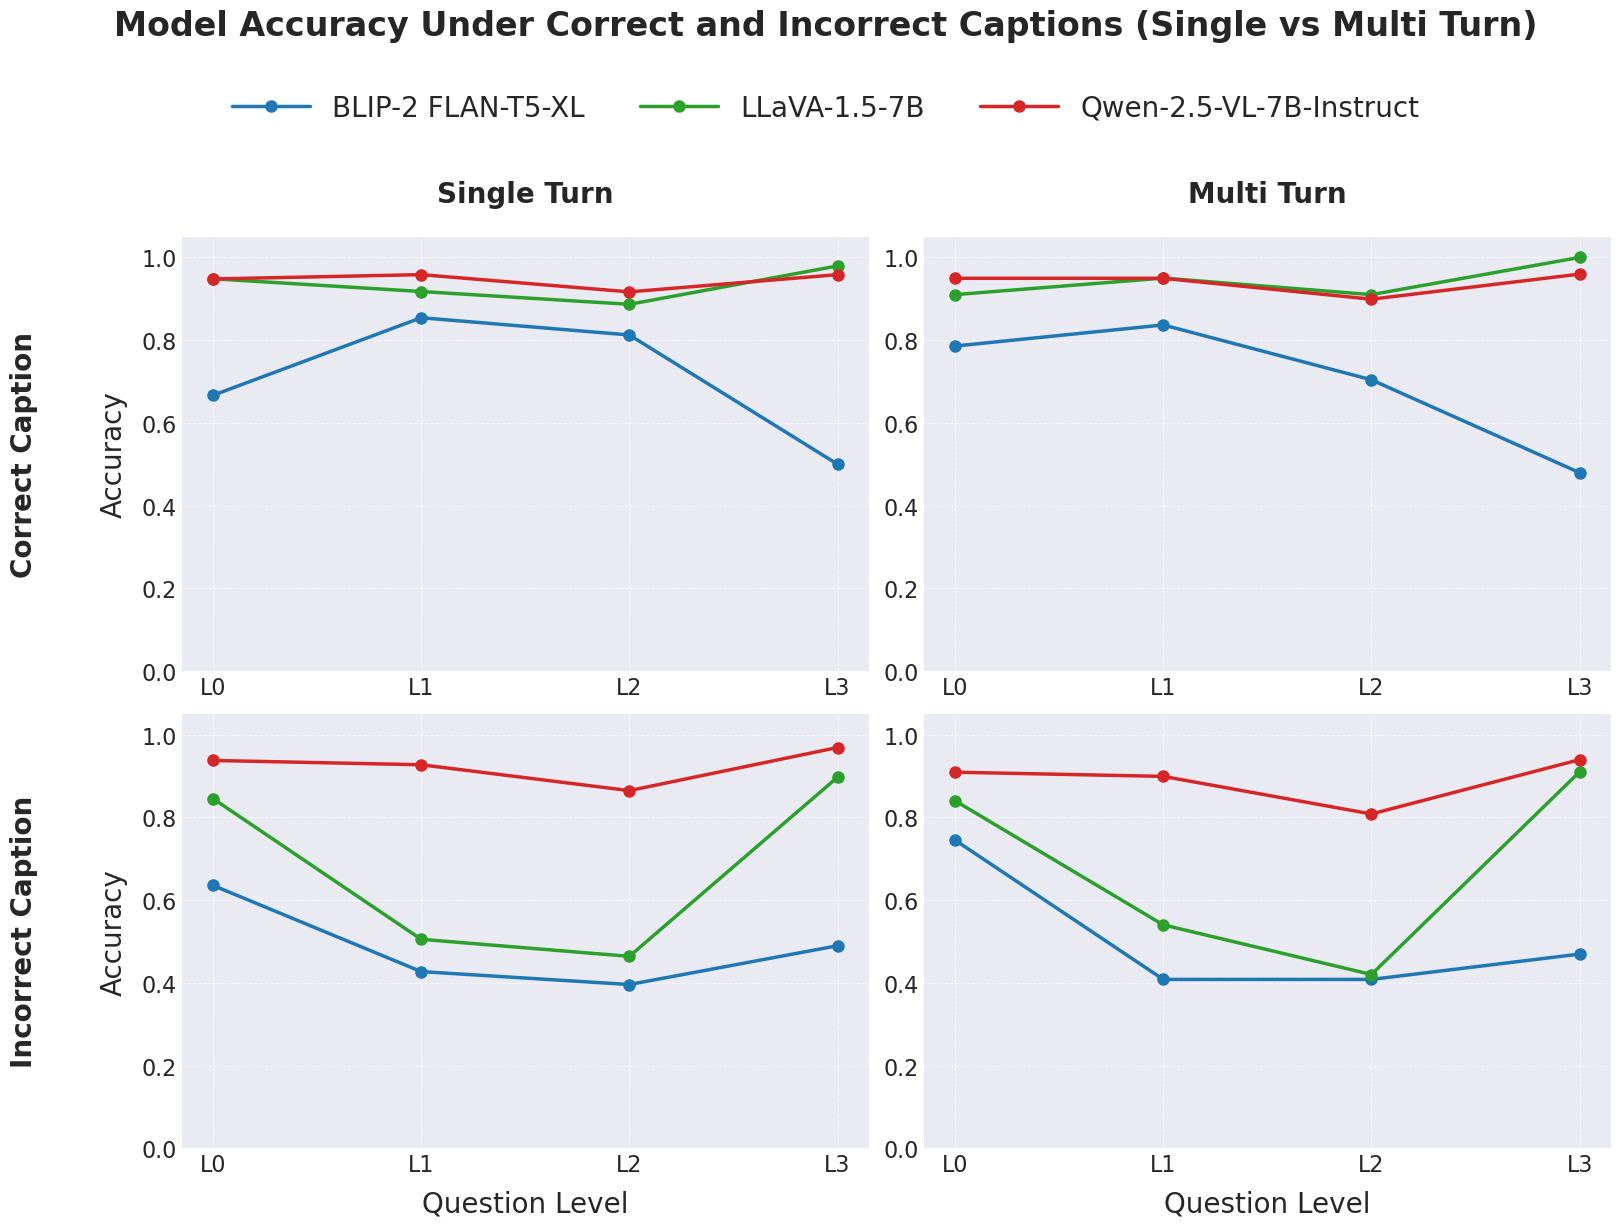

In [117]:
# ========= FILTER TO EVAL =========
df_eval = df_exp1_all[df_exp1_all.metric_type == "eval_scores"].copy()

levels = ["L0", "L1", "L2", "L3"]
df_eval["level"] = pd.Categorical(df_eval["level"], categories=levels, ordered=True)

# Model colors
model_colors = {
    "blip":  "#1f77b4",
    "llava": "#2ca02c",
    "qwen":  "#d62728",
}

# Legend name mapping
legend_names = {
    "blip":  "BLIP-2 FLAN-T5-XL",
    "llava": "LLaVA-1.5-7B",
    "qwen":  "Qwen-2.5-VL-7B-Instruct",
}

caption_types = ["correct_caption", "incorrect_caption"]
caption_labels = {
    "correct_caption": "Correct Caption",
    "incorrect_caption": "Incorrect Caption",
}

turn_types = ["single", "multi"]
turn_labels = {
    "single": "Single Turn",
    "multi": "Multi Turn",
}

plt.style.use("seaborn-v0_8-darkgrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=False)

# ========= MAIN LOOP =========
for i, caption in enumerate(caption_types):
    for j, turn in enumerate(turn_types):

        ax = axes[i][j]

        df_sub = df_eval[
            (df_eval.caption_type == caption) &
            (df_eval.turn_type == turn)
        ]

        # Plot each model line
        for model in ["blip", "llava", "qwen"]:
            df_plot = (
                df_sub[df_sub.model == model]
                .groupby("level")["value"].mean()
                .reset_index()
            )

            ax.plot(
                df_plot["level"],
                df_plot["value"],
                label=legend_names[model],
                color=model_colors[model],
                linewidth=2.5,
                marker="o",
                markersize=8
            )

        # Y-axis only on left column
        if j == 0:
            ax.set_ylabel("Accuracy", fontsize=20, labelpad=10)
        else:
            ax.set_ylabel("")

        # X-axis only on bottom row
        if i == 1:
            ax.set_xlabel("Question Level", fontsize=20, labelpad=10)
        else:
            ax.set_xlabel("")

        ax.tick_params(axis="both", labelsize=16)
        ax.set_ylim(0, 1.05)
        ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.6)

        # ---- COLUMN TITLES ("Single Turn", "Multi Turn") ----
        if i == 0:
            ax.set_title(turn_labels[turn], fontsize=20, fontweight="bold", pad=25)

        # ---- ROW TITLES ("Correct Caption", "Incorrect Caption") ----
        if j == 0:
            ax.annotate(
                caption_labels[caption],
                xy=(-0.25, 0.5),
                xycoords="axes fraction",
                fontsize=20,
                fontweight="bold",
                rotation=90,
                va="center"
            )

# ========= Global Title =========
fig.suptitle(
    "Model Accuracy Under Correct and Incorrect Captions (Single vs Multi Turn)",
    fontsize=24,
    fontweight="bold",
    y=1.02
)

# ========= Unified Legend =========
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center",
    ncol=3,
    fontsize=20,
    frameon=False,
    handlelength=2.8,
    bbox_to_anchor=(0.5, 0.97)
)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
